<a href="https://colab.research.google.com/github/ahmetdemiroz/ScanPy_Tutorial/blob/main/ScanPy_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **STEP 3**

### **ANALYZE DATA WITH SCANPY (SIMILAR TO SEURAT ANALYSIS IN R)**

**SOURCE:**
Barındırılan çalışma zamanına bağlanıldığında tekrar install edilmeleri gerekiyor.

Dataset: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz

Resource: https://youtu.be/aZIauqUp0oQ

Resource: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html


Resource: https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170501_moignard15/moignard15.ipynb

Resource: https://notebook.community/theislab/scanpy_usage/170501_moignard15/moignard15

In [ ]:
pip install scanpy

In [ ]:
pip install python-igraph

In [ ]:
pip install louvain

In [ ]:
#import scanpy.api as sc

Tutorial largely from the Theis lab: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170505_seurat/seurat.ipynb

Compare to Seurat tutorial for the same dataset: https://satijalab.org/seurat/articles/pbmc3k_tutorial.html



## **Import Dataset**



In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white') #low dpi (dots per inch) yields small inline figures
sc.logging.print_header()
results_file = '/content/drive/MyDrive/Colab_Notebooks/ScanPy_Tutorial/pbmc3k.h5ad'  # the file that will store the analysis results

scanpy==1.7.2 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.9.1 louvain==0.7.0


Read in the count matrix into an `AnnData <https://anndata.readthedocs.io/en/latest/anndata.AnnData.html>`__ object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: .h5ad.

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebooks/ScanPy_Tutorial/'
adata = sc.read(path + 'matrix.mtx', cache=True).T #transpose the data
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]

... reading from cache file cache/content-drive-MyDrive-Colab_Notebooks-ScanPy_Tutorial-matrix.h5ad


In [ ]:
"""# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan
adata = sc.read_10x_mtx(
    '/content/drive/MyDrive/Colab_Notebooks/ScanPy_Tutorial/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading"""

"# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan\nadata = sc.read_10x_mtx(\n    '/content/drive/MyDrive/Colab_Notebooks/ScanPy_Tutorial/',  # the directory with the `.mtx` file\n    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)\n    cache=True)                              # write a cache file for faster subsequent reading"

Variable names are not unique. to make them unique, call '.var_names_make_unique


In [ ]:
adata.var_names_make_unique()


## **Data preprocessing**

Show those genes that yield the highest fraction of counts in each single cell, across all cells.


normalizing counts per cell
    finished (0:00:00)


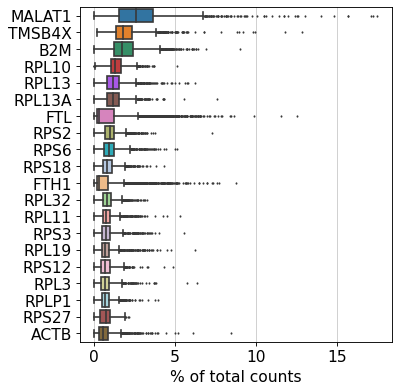

In [ ]:
# ScanPy tutorialdan
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering:

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [ ]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
#for each cell compute fraction of counts in mito genes vs. all genes
#the '.Al' is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
#add the total counts per cell as observation-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [ ]:
"""# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# With 'pp.calculate_qc_metrics', we can compute many metrics very efficiently."""

"# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan\nadata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'\nsc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)\n\n# With 'pp.calculate_qc_metrics', we can compute many metrics very efficiently."


Check number of genes, UMI counts, and percent mito for all cells:

A violin plot of some of the computed quality measures:

*   the number of genes expressed in the count matrix
*   the total counts per cell
*   the percentage of counts in mitochondrial genes

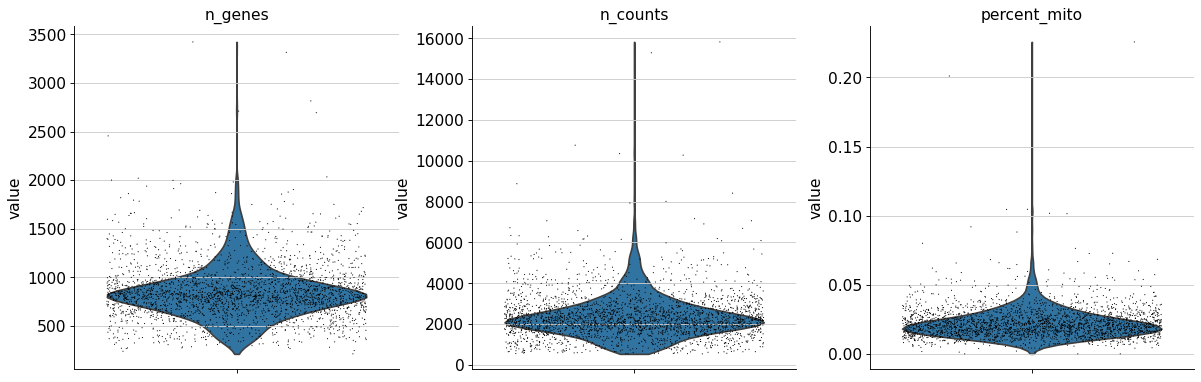

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], 
            jitter=0.4, multi_panel=True)

In [ ]:
"""# ScanPy tutorialdan üst blokla benzer işlev --> üsttekini kullan
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)"""

"# ScanPy tutorialdan üst blokla benzer işlev --> üsttekini kullan\nsc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],\n             jitter=0.4, multi_panel=True)"


Remove cells with too many genes or percent mitochondrial genes:


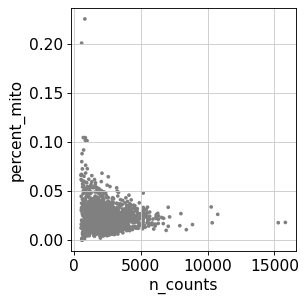

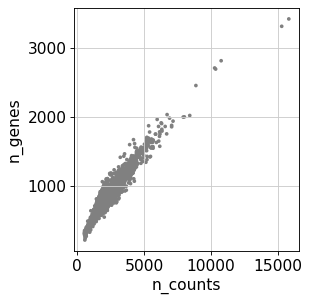

In [ ]:
# ScanPy tutorialdan
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
"""# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')"""

"# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan\nsc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')\nsc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')"

Actually do the filtering by slicing the AnnData object.

In [ ]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [ ]:
"""# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan
adata = adata[adata.obs['n_genes_by_counts'] < 2500, :]
adata = adata[adata.obs['pct_counts_mt'] < 5, :]"""

"# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan\nadata = adata[adata.obs['n_genes_by_counts'] < 2500, :]\nadata = adata[adata.obs['pct_counts_mt'] < 5, :]"


Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by sc.pp.log1p.


In [ ]:
adata.raw = sc.pp.log1p(adata, copy=True)


Per-cell normalize the matrix X, identify highly-variable genes:


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)


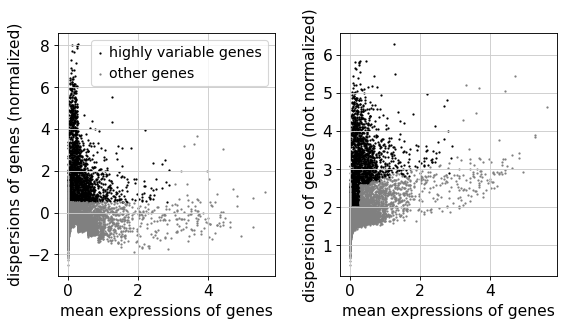

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [ ]:
"""# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan
#Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, 
#so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)
#Logarithmize the data:
sc.pp.log1p(adata)
#Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)"""

'# ScanPy tutorialdan üst blokla aynı işlev --> üsttekini kullan\n#Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, \n#so that counts become comparable among cells.\nsc.pp.normalize_total(adata, target_sum=1e4)\n#Logarithmize the data:\nsc.pp.log1p(adata)\n#Identify highly-variable genes.\nsc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)\nsc.pl.highly_variable_genes(adata)'


Percent of genes that are highly variable:


In [ ]:
sum(filter_result.gene_subset)/len(filter_result.gene_subset)*100

13.402362549219776


Filter out non-variable genes and view number of highly variable genes, which are retained:


In [ ]:
adata = adata[:, filter_result.gene_subset]
adata.shape[1]

1838

In [ ]:
sc.pp.log1p(adata)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:375: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.





In [ ]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
adata.write(results_file)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


In [ ]:
#Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use 
#->in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
#You can get back an AnnData of the object in .raw by calling .raw.to_adata().
#adata.raw = adata
#If you don’t proceed below with correcting the data with sc.pp.regress_out and scaling it via sc.pp.scale, you can 
#->also get away without using .raw at all.
#The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and 
#->auto-detected by PCA and hence, sc.pp.neighbors and subsequent manifold/graph tools. In that case, the step actually 
#->do the filtering below is unnecessary, too.
#Actually do the filtering
#adata = adata[:, adata.var.highly_variable]
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to 
#->unit variance.
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
#sc.pp.scale(adata, max_value=10)


## **Data Exploration**

### **PCA**

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.


In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
adata.obsm['X_pca'] *= -1    # multiply by -1 to match Seurat

computing PCA
    with n_comps=50
    finished (0:00:01)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.



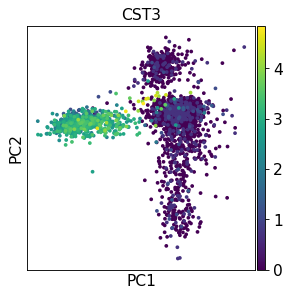

In [ ]:
sc.pl.pca_scatter(adata, color='CST3')

Examine the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). Often a rough estimate of the number of PCs does fine.



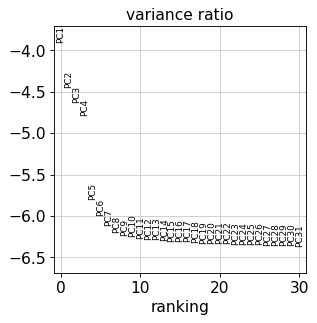

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [ ]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


## **tSNE**


In [ ]:
adata = sc.read(results_file)
sc.tl.tsne(adata, random_state=2, n_pcs=10)
adata.write(results_file)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:21)


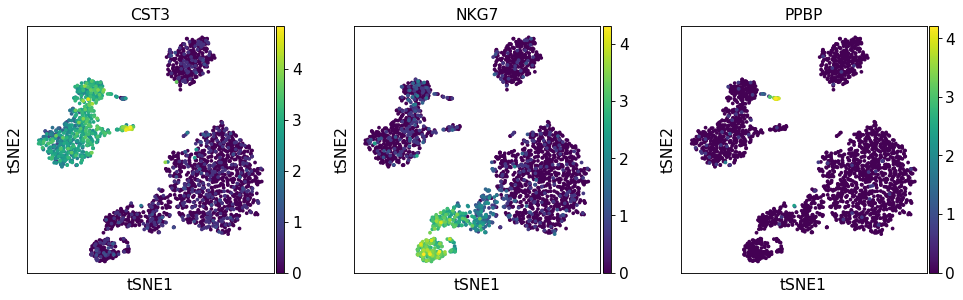

In [ ]:
sc.pl.tsne(adata, color=['CST3', 'NKG7', 'PPBP'])


The previous plots are for the raw data but the tSNE can also be run for only the filtered data:


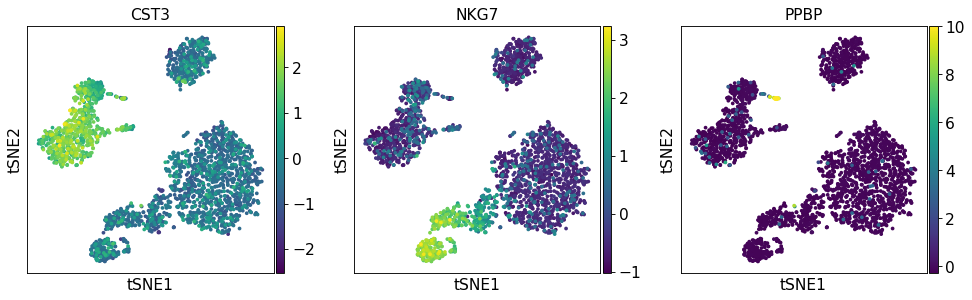

In [ ]:
sc.pl.tsne(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)


## **UMAP**

UMAP is a more recent dimensionality reduction technique (see arXiv paoer from February 9, 2018 here: https://arxiv.org/abs/1802.03426).

According to the authors: "The UMAP algorithm is **competitive with t-SNE for visualization quality**, and arguably preserves more of the global structure with **superior run time performance**. Furthermore, UMAP as described has no computational restrictions on embedding dimension, making it viable as a general purpose dimension reduction technique for machine learning."

Yazarlara göre: "UMAP algoritması, görselleştirme kalitesi için t-SNE ile rekabetçidir ve tartışmalı bir şekilde, üstün çalışma süresi performansı ile küresel yapının daha fazlasını korur.
Ayrıca, UMAP'nin açıklandığı gibi gömme boyutunda herhangi bir hesaplama kısıtlaması yoktur, bu da onu makine öğrenimi için genel amaçlı bir boyut azaltma tekniği olarak uygulanabilir kılar. "

First, a neighborhood graph must be computed:

In [ ]:
adata = sc.read(results_file)
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


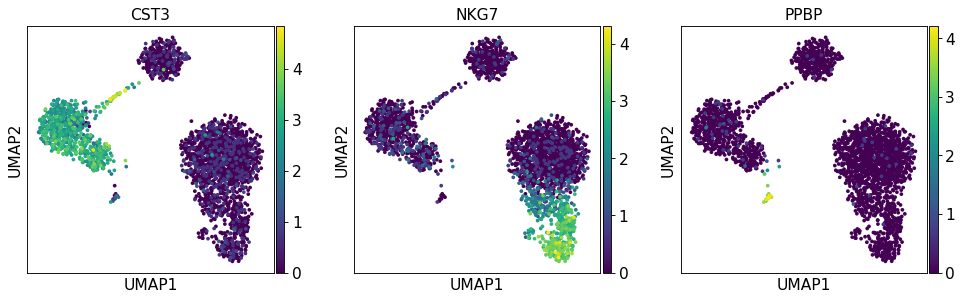

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

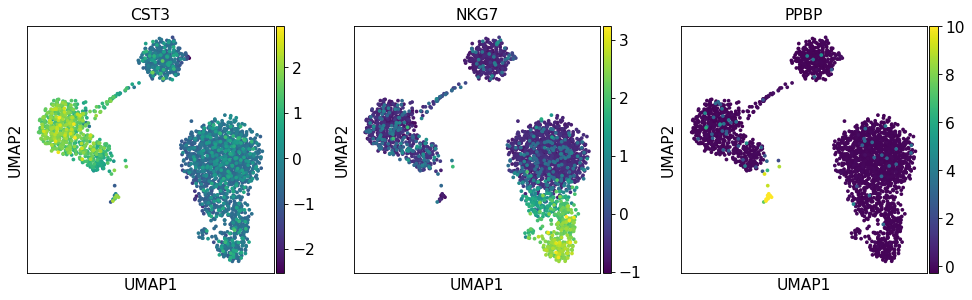

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [ ]:
#pip install python-igraph

In [ ]:
#pip install louvain


## **Clustering**

As Seurat and many others, the ScanPy creators - the Theis lab - use the Louvain graph-clustering method (community detection based on optimizing modularity.)

It has been proposed for single-cell data by Levine et al. (2015): https://www.ncbi.nlm.nih.gov/pubmed/26095251


In [ ]:
import community
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


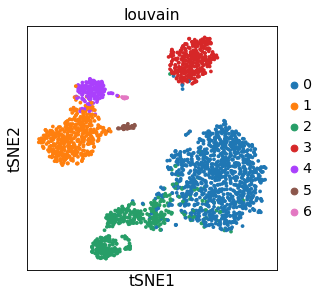

In [ ]:
sc.pl.tsne(adata, color='louvain')

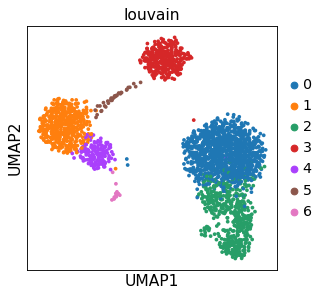

In [ ]:
sc.pl.umap(adata, color='louvain')

In [ ]:
adata.write(results_file)


## **Find marker genes in each cluster:**

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


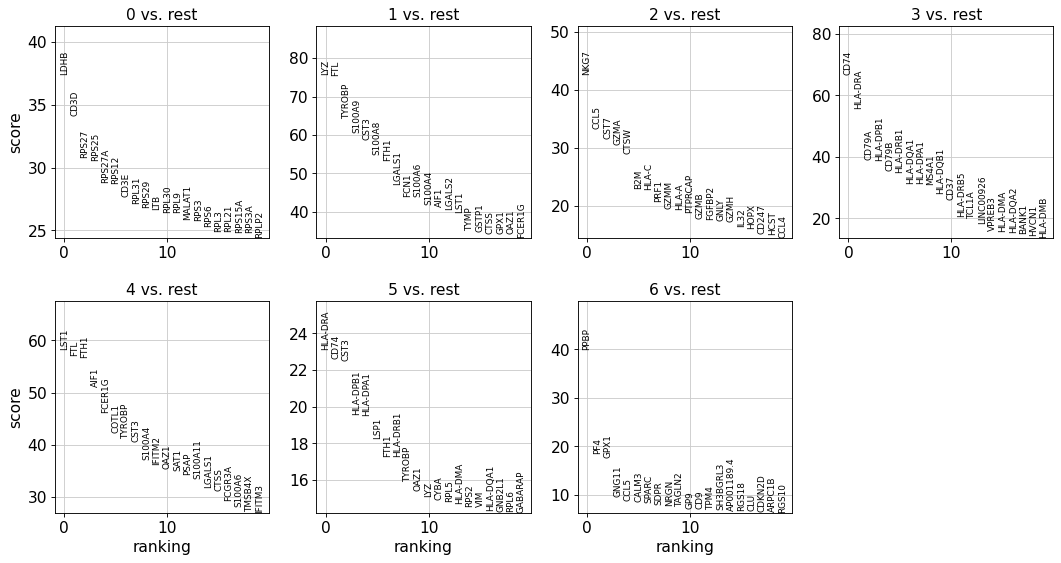

In [ ]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain')
# sc.pl.rank_genes_groups(adata, n_genes=20, save='.pdf')
sc.pl.rank_genes_groups(adata, n_genes=20, save='.pdf', sharey=False)
adata.write(results_file)

The images are saved this location, /content/figures/rank_genes_groups_louvain.pdf 

In [ ]:
sc.settings.verbosity = 2   # reduce the verbosity to no longer see hints
#adata.write(results_file)

Here, genes are ranked using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The Theis lab finds that this works very well.
Here, it recovers known marker genes at higher ranking than using a t-test or Wilcoxon rank sum test.

Burada genler, lojistik regresyon kullanılarak sıralanır. Örneğin, bu Natranos ve ark. (2018). Theis laboratuvarı bunun çok iyi çalıştığını tespit etti. Burada, bir t-testi veya Wilcoxon sıra toplamı testi kullanmaktan daha yüksek sıralamada bilinen işaretçi genleri kurtarır.

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
#sc.tl.rank_genes_groups(adata, 'louvain', method='logreg', status=1)

ranking genes
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
    finished (0:00:12)


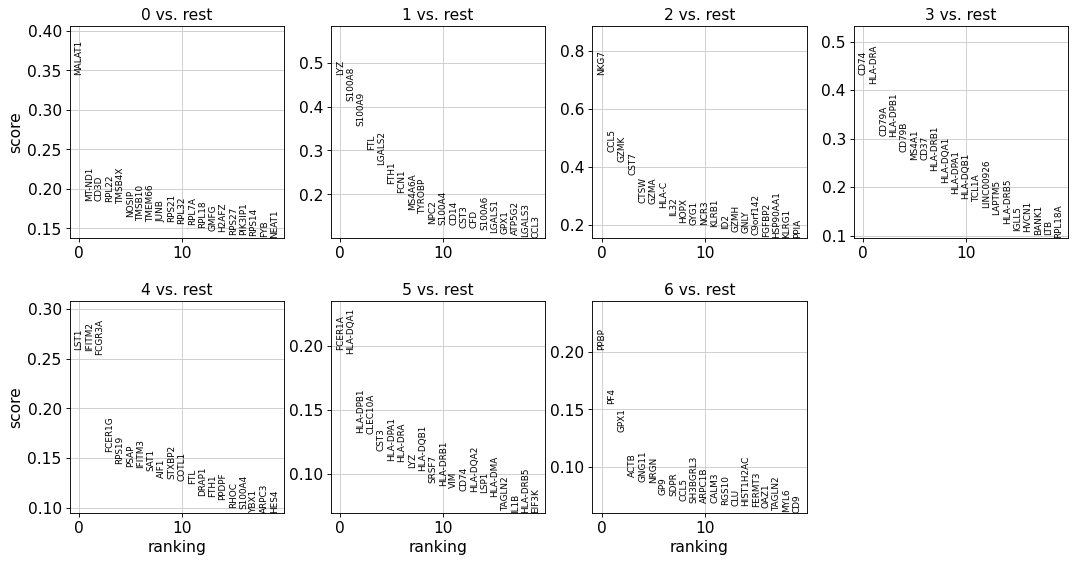

In [ ]:
#sc.pl.rank_genes_groups(adata, n_genes=20)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

Top genes per cluster:

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6
0,MALAT1,LYZ,NKG7,CD74,LST1,FCER1A,PPBP
1,MT-ND1,S100A8,CCL5,HLA-DRA,IFITM2,HLA-DQA1,PF4
2,CD3D,S100A9,GZMK,CD79A,FCGR3A,HLA-DPB1,GPX1
3,RPL22,FTL,CST7,HLA-DPB1,FCER1G,CLEC10A,ACTB
4,TMSB4X,LGALS2,CTSW,CD79B,RPS19,CST3,GNG11


See scores for each gene in addition to names:

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,5_n,5_s,6_n,6_s
0,MALAT1,0.343854,LYZ,0.471448,NKG7,0.716424,CD74,0.430753,LST1,0.258669,FCER1A,0.196533,PPBP,0.201339
1,MT-ND1,0.185035,S100A8,0.412553,CCL5,0.453149,HLA-DRA,0.414117,IFITM2,0.257573,HLA-DQA1,0.193832,PF4,0.154460
2,CD3D,0.184484,S100A9,0.357305,GZMK,0.418354,CD79A,0.306551,FCGR3A,0.254271,HLA-DPB1,0.132002,GPX1,0.130466
3,RPL22,0.183740,FTL,0.300647,CST7,0.371983,HLA-DPB1,0.303129,FCER1G,0.156775,CLEC10A,0.131615,ACTB,0.091073
4,TMSB4X,0.181081,LGALS2,0.268113,CTSW,0.278322,CD79B,0.273336,RPS19,0.143883,CST3,0.117901,GNG11,0.087207


Compare to a single cluster:

In [ ]:
#sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='logreg')
#sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

More detailed view for a single group:

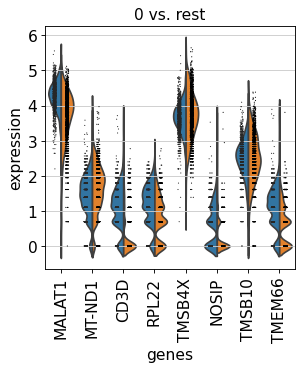

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

We can also comparea few genes across all groups:

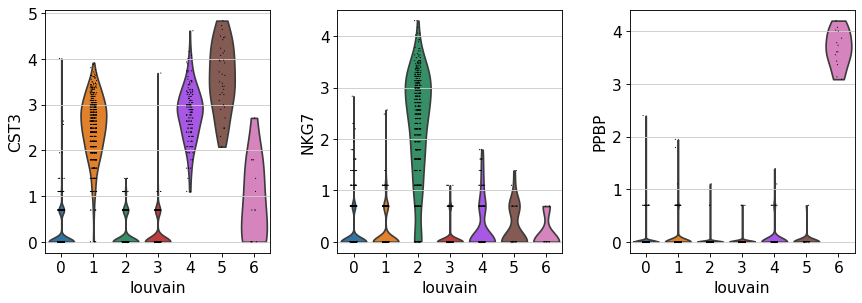

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

# **/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

# **/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

## **Başka denemeler1...............**


Compare to a single cluster:

ranking genes
    finished (0:00:00)


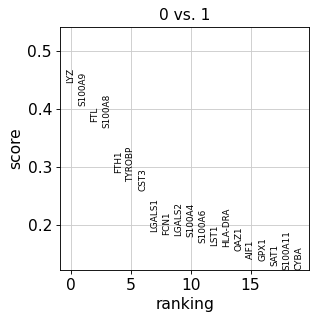

In [ ]:
adata2 = sc.read(results_file)

sc.tl.rank_genes_groups(adata2, 'louvain', groups=['0'], reference='1', method='logreg')
sc.pl.rank_genes_groups(adata2, groups=['0'], n_genes=20)

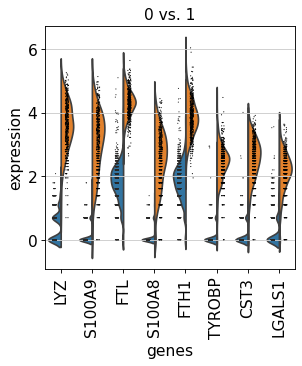

In [ ]:
sc.pl.rank_genes_groups_violin(adata2, groups='0', n_genes=8)

# **/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

# **/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

## **Başka denemeler2...............**


    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9954014  0.9904074  0.9780695  0.9605745  0.9528901
     0.93721557 0.8591395  0.84147197 0.835898   0.7982652  0.7944291
     0.78551257 0.7627667  0.7603423 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


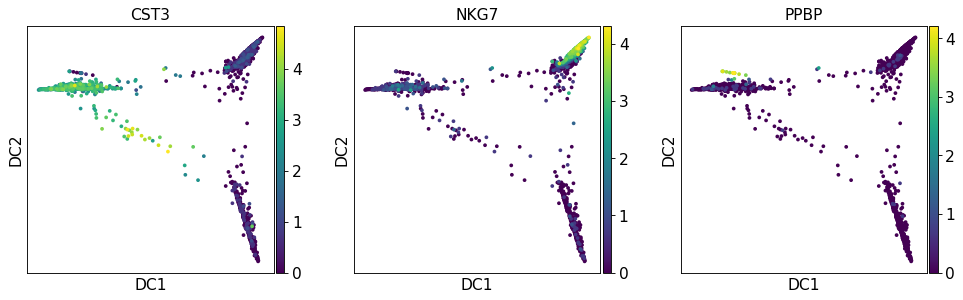

In [ ]:
sc.tl.dpt(adata, n_branchings=1)
sc.pl.diffmap(adata, color=['CST3', 'NKG7', 'PPBP'])

# **/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

# **/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

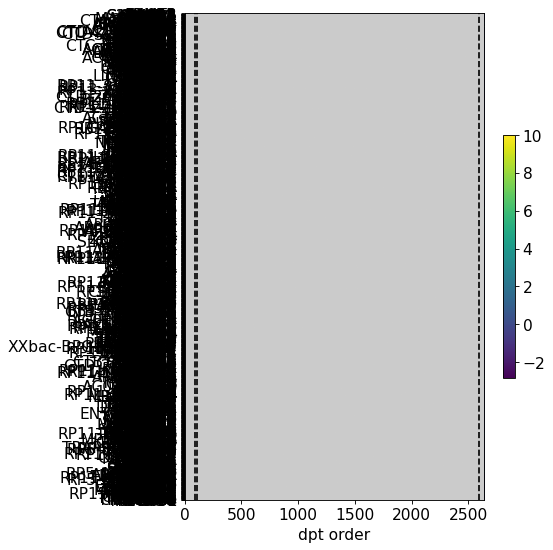

In [ ]:
sc.pl.dpt_timeseries(adata)

# **/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

# **/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

## **STEP 4**

### **USE DIFFUSION PSEUDOTIME TO ORDER HEMATOPOIETIC DEVELOPMENT**

Resource: https://youtu.be/aZIauqUp0oQ

Resource: https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170501_moignard15/moignard15.ipynb

Resource: https://notebook.community/theislab/scanpy_usage/170501_moignard15/moignard15

## **Pseudotime**

Adapted from the Theis lab tutorial here: https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170501_moignard15/moignard15.ipynb

Scanpy also has methods to calculate diffusion pseudotime, described in Haghverdi et al (2016)

According to the authors: "The  **temporal order of differentiating cells is instrinsically encoded in their single-cell expression profiles.** We describe an efficient way to robustly estimate this order according to diffusion pseudotime (DPT), which measures transitions between cell using diffusion-like random walks. Our DPT software implementations make it possible to **reconstruct the developmental progression of cells** and identify transient or metastable states, branching decisions and differentiation endpoints."

In [ ]:
sc.settings_verbosity = 3   #verbosity: error (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)   #low dpi (dots per inch) yields small inline figures
sc.logging.print_header()
results_file2 = '/content/drive/MyDrive/Colab_Notebooks/ScanPy_Tutorial/moignard15.h5ad'

scanpy==1.7.2 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.9.1 louvain==0.7.0



The available data is single-cell qPCR data. It is already on a logarithmic scale and pretty low-dimensional. We do not have to perform extensive preprocessing.

First we import the data and filter out a few genes:


In [ ]:
"""filename = 'data/moignard15/nbt.3154-S3.xlsx'
# the url is used to download the file if it's not there yet
backup_url = 'http://www.nature.com/nbt/journal/v33/n3/extref/nbt.3154-S3.xlsx'
adata = sc.read(filename, sheet='dCt_values.txt', cache=True, backup_url=backup_url)
# filter out genes as done by Haghverdi et al. (2016)
gene_subset = ~np.inld(adata.var_names, ['Eif2b1', 'Mrpl19', 'Polr2a', 'Ubc'])
# get a new AnnData object retain non-removed genes
adata = adata[:, gene_subset]"""

"filename = 'data/moignard15/nbt.3154-S3.xlsx'\n# the url is used to download the file if it's not there yet\nbackup_url = 'http://www.nature.com/nbt/journal/v33/n3/extref/nbt.3154-S3.xlsx'\nadata = sc.read(filename, sheet='dCt_values.txt', cache=True, backup_url=backup_url)\n# filter out genes as done by Haghverdi et al. (2016)\ngene_subset = ~np.inld(adata.var_names, ['Eif2b1', 'Mrpl19', 'Polr2a', 'Ubc'])\n# get a new AnnData object retain non-removed genes\nadata = adata[:, gene_subset]"

In [ ]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

This is single-cell qPCR data. It's already on a logrithmic scale and pretty low-dimensional. We do not have to perform extensive preprocessing.
*   Filter out a few genes.
*   Choose a 'root cell'.
*   LDefine groupnames by inspecting cellnames.




In [ ]:
adata = sc.datasets.moignard15()

In [ ]:
sc.pp.neighbors(adata, n_neighbors=5, method='gauss', knn=False)

computing neighbors
    using data matrix X directly
    finished (0:00:01)


Compute branchings and diffusion pseudotime using DPT.

In [ ]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:07)
    eigenvalues of transition matrix
    [1.0000018  0.99249375 0.9739005  0.8865169  0.8607167  0.8255125
     0.78051543 0.75996214 0.73387086 0.7300987  0.71366423 0.7079265
     0.70568436 0.6916952  0.69011796]
    finished (0:00:09)


In [ ]:
sc.tl.dpt(adata, n_branchings=1, n_dcs=10)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:01)


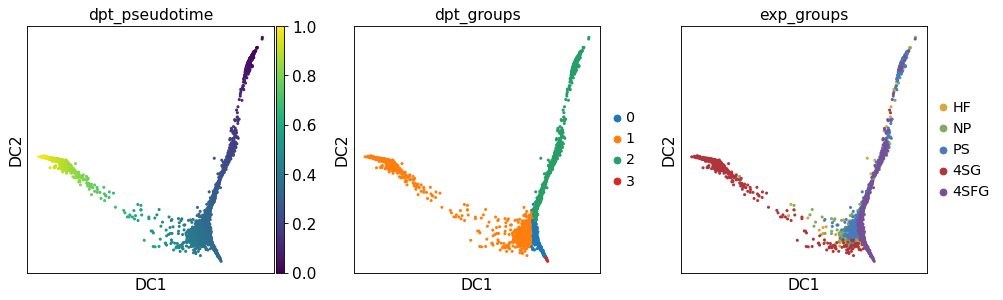

In [ ]:
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups', 'exp_groups'])

/usr/local/lib/python3.7/dist-packages/scanpy/plotting/_utils.py:119: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, None]


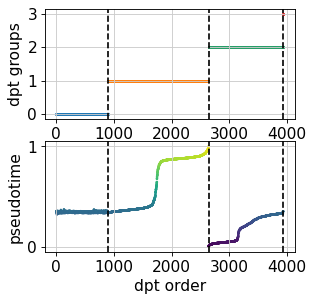

In [ ]:
sc.pl.dpt_groups_pseudotime(adata)

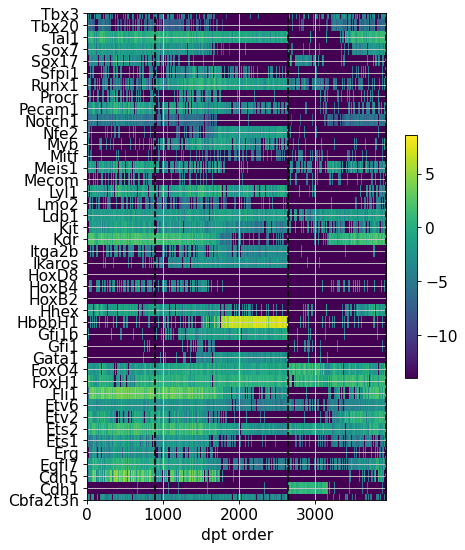

In [ ]:
sc.pl.dpt_timeseries(adata)

Let us annotate the cell groups as follows.

In [ ]:
adata.rename_categories('dpt_groups', ['undecided/endothelial', 'erythrocytes', 'trunk', 'endothelial'])

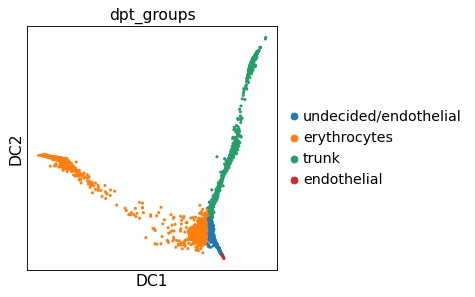

In [ ]:
sc.pl.diffmap(adata, color='dpt_groups')

Save the results.

In [ ]:
adata.write(results_file2)

Or as csv.

In [ ]:
adata.obs.to_csv('/content/drive/MyDrive/Colab_Notebooks/ScanPy_Tutorial/annotation.csv')
# To write the full object to csvs
adata.write_csvs('/content/drive/MyDrive/Colab_Notebooks/ScanPy_Tutorial/moignard15.csv')

writing .csv files to /content/drive/MyDrive/Colab_Notebooks/ScanPy_Tutorial/moignard15
